# Tide gauge download
This notebook downloads the tide gauge data from the University of Hawaii Sea Level Center using ERDDAP and then converts the data into a format for analysis.

In [1]:
import numpy as np
import xarray as xr
import cftime
import pandas as pd
from erddapy import ERDDAP

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import re
import os
import glob

import attrs, utils

VIS_PATH = attrs.VISUALIZATION_PATH

Submit tabledap request using erddapy to get a table of all daily tide gauge data available

In [2]:
## Submit tabledap request (~60 seconds)
# server = 'http://erddap.dataexplorer.oceanobservatories.org/erddap'
server = 'https://uhslc.soest.hawaii.edu/erddap/'

e = ERDDAP(
    server=server,
    protocol='tabledap'
)


e.dataset_id = 'global_daily_rqds'
e.constraints = {
    'time>=': '{}Z'.format(attrs.tmin),     # Maximum time range
    'time<=': '{}Z'.format(attrs.tmax)
}
e.variables = [
    'time',
    'sea_level',
    'station_name',
    'uhslc_id',
    'record_id',
    'latitude',
    'longitude'
]

print(e.get_download_url())    # Print URL for query

e.response = 'csv'
df = e.to_pandas()
df.head()

https://uhslc.soest.hawaii.edu/erddap/tabledap/global_daily_rqds.html?time,sea_level,station_name,uhslc_id,record_id,latitude,longitude&time>=-3912753600.0&time<=1564401600.0


,time (UTC),sea_level (millimeters),station_name,uhslc_id,record_id,latitude (degrees_north),longitude (degrees_east)
0,1969-05-09T12:00:00Z,725.0,Pohnpei,1,11,6.983,158.233
1,1969-05-10T12:00:00Z,715.0,Pohnpei,1,11,6.983,158.233
2,1969-05-11T12:00:00Z,719.0,Pohnpei,1,11,6.983,158.233
3,1969-05-12T12:00:00Z,740.0,Pohnpei,1,11,6.983,158.233
4,1969-05-13T12:00:00Z,740.0,Pohnpei,1,11,6.983,158.233


## Clean up the dataframe

1. Modify dataframe so that times are represented as cftime.DatetimeGregorian objects and can be used with xarray's plotting interface
2. Standardize station names (remove typos, drop unnecessary terms)
3. Create unique station names: Christmas island (Indian ocean, ID#170) and Kiritimati (Pacific, a.k.a Christmas island, ID#11) are both referred to as 'Christmas' in the dataframe. To avoid ambiguity we modify the dataframe so that the Pacific christmas island is given the name 'Kiritimati' instead.

In [3]:
# Modify so that times are cftime gregorian objects
def convert_to_cftime(datestring):
    year = int(datestring[0:4])
    month = int(datestring[5:7])
    day = int(datestring[8:10])
    # return cftime.datetime(year, month, day, hour=12, calendar='gregorian')
    return cftime.DatetimeGregorian(year, month, day, hour=12)

def station_name_standardizer(station_name):
    station_names_dict = {
        'Tarawa, Betio' : 'Tarawa',
        'Tarawa, Bairiki' : 'Tarawa',
        'Baltra, Galapagos': 'Baltra',
        'Male, Hulule': 'Male',
        'Cilicap' : 'Cilacap',
        'Fortaleza, USCGS': 'Fortaleza',
        'Puerto Quetza' : 'Puerto Quetzal',
        'Salvador, USCGS': 'Salvador'
    }
    if station_name in station_names_dict.keys():
        return station_names_dict[station_name]
    else:
        return station_name

df['time (UTC)'] = df['time (UTC)'].apply(convert_to_cftime)
df['station_name'] = df['station_name'].apply(station_name_standardizer)

df.loc[df['uhslc_id'] == 11, 'station_name'] = 'Kiritimati'

In [4]:
# Quality checks
multiple_names = df.groupby('uhslc_id')['station_name'].nunique() > 1
multiple_names[multiple_names]    # Returns empty if every station ID has unique station name

Series([], Name: station_name, dtype: bool)

Get list of station names and ids:

In [5]:
station_names = np.unique(df['station_name'])
station_ids = np.unique(df['uhslc_id'])

Count number of unique instances of station ids, record ids, station names and coordinate pairs. From this, it looks like some tide gauges are given different names and change coordinates a few times. But with the station_name_standardizer function and handling of repeat station_names, the number of unique station IDs is consistent with the number of station names.

In [6]:
# Number of unique station ids, station names, and coordinate pairs
print(len(station_ids))
print(len(np.unique(df['record_id'])))
print(len(station_names))
print(df.groupby(['latitude (degrees_north)', 'longitude (degrees_east)']).ngroups)   # Number of lat-lon coord pairs

548
696
548
611


Here, we create a xr.DataArray of tide gauge data at a particular location. This is using UHSLC station ID #1, which is a tide gauge at Pohnpei. We also plot the data.

<xarray.DataArray 'sea_level' (time: 18096)>
array([725., 715., 719., ..., 684., 665., 641.])
Coordinates:
  * time     (time) object 1969-05-09 12:00:00 ... 2018-12-31 12:00:00
Attributes:
    station_id:             1
    station_name:           Pohnpei
    units:                  mm
    latitude [Degrees N]:   [6.983 6.987 6.978]
    longitude [Degrees E]:  [158.233 158.243 158.197]
    long_name:              Relative sea level, station ID #1 (Pohnpei)

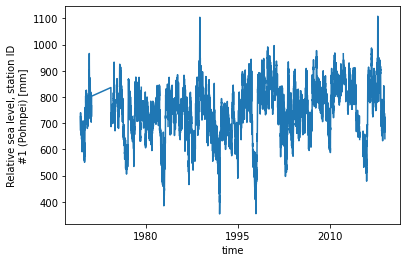

In [15]:
# Explore timeseries at particular location
i = 1    # ID of Pohnpei tide gauge
gauge_df = df[df.uhslc_id == i]

if gauge_df['station_name'].nunique() == 1:
    station_name = gauge_df['station_name'].values[0]
else:
    station_name = gauge_df['station_name'].unique()

if gauge_df['latitude (degrees_north)'].nunique() == 1:
    station_lat = gauge_df['latitude (degrees_north)'][0]
else:
    station_lat = gauge_df['latitude (degrees_north)'].unique()

if gauge_df['longitude (degrees_east)'].nunique() == 1:
    station_lon = gauge_df['longitude (degrees_east)'][0]
else:
    station_lon = gauge_df['longitude (degrees_east)'].unique()

darray = xr.DataArray(
    data=gauge_df['sea_level (millimeters)'],
    dims=('time',),
    coords={'time' : gauge_df['time (UTC)']},
    name='sea_level',
    attrs={
        'station_id': i,
        'station_name': station_name,
        'units': 'mm',
        'latitude [Degrees N]': station_lat,
        'longitude [Degrees E]': station_lon,
        'long_name': 'Relative sea level, station ID #{} ({})'.format(i, station_name)
    }
)
darray.plot()
darray

## Save dictionary of xarray.Dataset objects

These distinct dataarrays cannot be amalgamated into a single dataset, because they have different time coordinates. Because we can't save it as a dataset anyway, we can save a dictionary of the dataarrays instead. However, the dataarrays restrict the amount of data we can save about the tide gauges, so we will try to save each tide gauge station ID as a separate xr.Dataset object.

Each dataset will have the following variables:

* sea_level : the observed RSL at a particular location.
  * station_id : i
  * long_name : 'Observed relative sea level at {station_name}'
  * units : 'mm'
  * name : 'sea_level'
  * station_name : station_name
* record_id : the unique identifier for each record
  * long_name : 'unique identifier for each record (i.e., station and version) in the database'
* latitude
  * units : 'Degrees N'
* longitude
  * units : 'Degrees E'

We'll do this for Pohnpei as an example, and then for each station in the following cell.

In [9]:
i = 1    # ID of Pohnpei tide gauge
# Data and attributes
gauge_df = df[df.uhslc_id == i]
station_name = gauge_df['station_name'].values[0]    # Is unique
lat_estimate = np.round(gauge_df['latitude (degrees_north)'].unique().mean(), 1)
lon_estimate = np.round(gauge_df['longitude (degrees_east)'].unique().mean(), 1)
num_obs = len(gauge_df['sea_level (millimeters)'].dropna())
num_record_changes = gauge_df['record_id'].nunique() - 1
first_record = str(
    gauge_df[~gauge_df['sea_level (millimeters)'].isna()]['time (UTC)'].iloc[0]
)[0:10]
last_record = str(
    gauge_df[~gauge_df['sea_level (millimeters)'].isna()]['time (UTC)'].iloc[-1]
)[0:10]

# Create DataArrays
time = gauge_df['time (UTC)']
sea_level = xr.DataArray(
    data=gauge_df['sea_level (millimeters)'],
    dims=('time',),
    coords={'time' : time},
    name='sea_level',
    attrs={
        'station_id' : i,
        'station_name' : station_name,
        'long_name': 'In-situ observed relative sea level at {}'.format(station_name),
        'units' : 'mm',
    }
)
record_id = xr.DataArray(
    data=gauge_df['record_id'],
    dims=('time',),
    coords={'time' : time},
)
latitude = xr.DataArray(
    data=gauge_df['latitude (degrees_north)'],
    dims=('time',),
    coords={'time' : time},
)
longitude = xr.DataArray(
    data=gauge_df['longitude (degrees_east)'],
    dims=('time',),
    coords={'time' : time},
)

gauge_ds = xr.Dataset(
    {
        'sea_level': sea_level,
        'record_id': record_id,
        'latitude' : latitude,
        'longitude': longitude
    },
    attrs = {
        'station_id' : i,
        'station_name' : station_name,
        'num_days': num_obs,
        'first_record_date': first_record,
        'last_record_date' : last_record,
        'num_record_changes': num_record_changes,
        'approx_lat' : lat_estimate,
        'approx_lon': lon_estimate,
    }
)
gauge_ds

<xarray.Dataset>
Dimensions:    (time: 18096)
Coordinates:
  * time       (time) object 1969-05-09 12:00:00 ... 2018-12-31 12:00:00
Data variables:
    sea_level  (time) float64 725.0 715.0 719.0 740.0 ... 684.0 665.0 641.0
    record_id  (time) int64 11 11 11 11 11 11 11 11 ... 13 13 13 13 13 13 13 13
    latitude   (time) float64 6.983 6.983 6.983 6.983 ... 6.978 6.978 6.978
    longitude  (time) float64 158.2 158.2 158.2 158.2 ... 158.2 158.2 158.2
Attributes:
    station_id:          1
    station_name:        Pohnpei
    num_days:            17498
    first_record_date:   1969-05-09
    last_record_date:    2018-12-31
    num_record_changes:  2
    approx_lat:          7.0
    approx_lon:          158.2

Some plots to show the timeseries and location of the tide gauges:

Text(0.5, 1.0, 'Location of tide gauges')

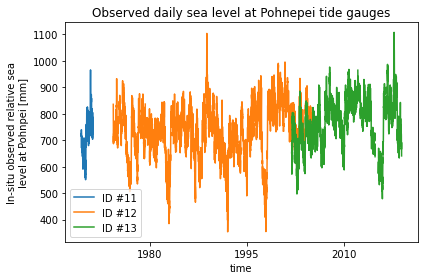

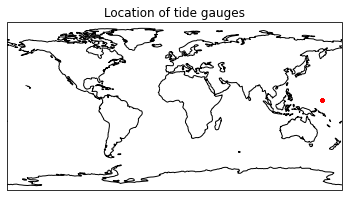

In [17]:
fig, ax = plt.subplots()
for i in range(3):
    record_num = np.unique(gauge_ds['record_id'])[i]
    (
        gauge_ds['sea_level']
        .where(gauge_ds['record_id'] == record_num)
        .plot(ax=ax, color='C{}'.format(i), label='ID #{}'.format(record_num))
    )
ax.legend()
ax.set_title('Observed daily sea level at Pohnepei tide gauges')
fig.tight_layout()

fig, ax = plt.subplots(subplot_kw={'projection' : ccrs.PlateCarree()})
ax.scatter(gauge_ds.longitude, gauge_ds.latitude, 
    color='r', s=5, transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.set_global()
ax.set_title('Location of tide gauges')

Now, let's put all of the tide gauges into the same dictionary:

In [19]:
tide_gauges_dict = {}
for i in df['uhslc_id'].unique():
    # Data and attributes
    gauge_df = df[df.uhslc_id == i]
    station_name = gauge_df['station_name'].values[0]    # Is unique
    lat_estimate = np.round(gauge_df['latitude (degrees_north)'].unique().mean(), 1)
    lon_estimate = np.round(gauge_df['longitude (degrees_east)'].unique().mean(), 1)
    num_obs = len(gauge_df['sea_level (millimeters)'].dropna())
    num_record_changes = gauge_df['record_id'].nunique() - 1
    first_record = str(
        gauge_df[~gauge_df['sea_level (millimeters)'].isna()]['time (UTC)'].iloc[0]
    )[0:10]
    last_record = str(
        gauge_df[~gauge_df['sea_level (millimeters)'].isna()]['time (UTC)'].iloc[-1]
    )[0:10]

    # Create DataArrays
    time = gauge_df['time (UTC)']
    sea_level = xr.DataArray(
        data=gauge_df['sea_level (millimeters)'],
        dims=('time',),
        coords={'time' : time},
        name='sea_level',
        attrs={
            'station_id' : i,
            'station_name' : station_name,
            'long_name': 'In-situ observed relative sea level at {}'.format(station_name),
            'units' : 'mm',
        }
    )
    record_id = xr.DataArray(
        data=gauge_df['record_id'],
        dims=('time',),
        coords={'time' : time},
    )
    latitude = xr.DataArray(
        data=gauge_df['latitude (degrees_north)'],
        dims=('time',),
        coords={'time' : time},
    )
    longitude = xr.DataArray(
        data=gauge_df['longitude (degrees_east)'],
        dims=('time',),
        coords={'time' : time},
    )

    gauge_ds = xr.Dataset(
        {
            'sea_level': sea_level,
            'record_id': record_id,
            'latitude' : latitude,
            'longitude': longitude
        },
        attrs = {
            'station_id' : i,
            'station_name' : station_name,
            'num_days': num_obs,
            'first_record_date': first_record,
            'last_record_date': last_record,
            'num_record_changes': num_record_changes,
            'approx_lat' : lat_estimate,
            'approx_lon': lon_estimate,
        }
    )
    tide_gauges_dict[station_name] = gauge_ds

<xarray.Dataset>
Dimensions:    (time: 36007)
Coordinates:
  * time       (time) object 1920-06-02 12:00:00 ... 2018-12-31 12:00:00
Data variables:
    sea_level  (time) float64 1.593e+03 1.605e+03 ... 1.789e+03 1.91e+03
    record_id  (time) int64 7451 7451 7451 7451 7451 ... 7451 7451 7451 7451
    latitude   (time) float64 40.7 40.7 40.7 40.7 40.7 ... 40.7 40.7 40.7 40.7
    longitude  (time) float64 286.0 286.0 286.0 286.0 ... 286.0 286.0 286.0
Attributes:
    station_id:          745
    station_name:        New York, NY
    num_days:            31358
    first_record_date:   1920-06-02
    last_record_date:    2018-12-31
    num_record_changes:  0
    approx_lat:          40.7
    approx_lon:          286.0

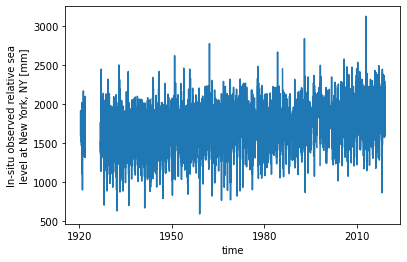

In [20]:
# Check dictionary
tide_gauges_dict.keys()
nyc_sl = tide_gauges_dict['New York, NY'].sea_level
nyc_sl.plot()
nyc_sl
tide_gauges_dict['New York, NY']

Save the dictionary using numpy:

In [23]:
np.save('../data/daily_tide_gauges_dict.npy', tide_gauges_dict)

The `utils` file was modified to load the dictionary, so we can just retrieve the dictionary with `utils.load_tide_gauges_dict()`.

In [24]:
d = utils.load_tide_gauges_dict()
# list(d.items())[0:5]

## Plots of global tide gauge datasets

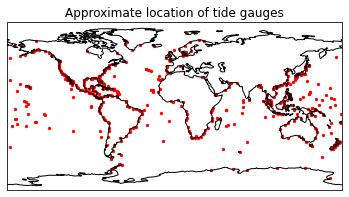

In [36]:
# Plot tide gauge locations
fig, ax = plt.subplots(subplot_kw={'projection' : ccrs.PlateCarree()})
for station_name in d:
    ax.scatter(d[station_name].attrs['approx_lon'], d[station_name].attrs['approx_lat'], 
        color='r', s=5, transform=ccrs.PlateCarree()
    )
ax.coastlines()
ax.set_global()
ax.set_title('Approximate location of tide gauges')

fig.savefig(os.path.join(VIS_PATH, 'tide_gauge_locations'))

In [37]:
list(d.keys())[0:10]

['Pohnpei',
 'Tarawa',
 'Baltra',
 'Nauru',
 'Majuro',
 'Enewetok',
 'Malakal',
 'Yap',
 'Honiara',
 'Rabaul']

<xarray.Dataset>
Dimensions:    (time: 18096)
Coordinates:
  * time       (time) object 1969-05-09 12:00:00 ... 2018-12-31 12:00:00
Data variables:
    sea_level  (time) float64 725.0 715.0 719.0 740.0 ... 684.0 665.0 641.0
    record_id  (time) int64 11 11 11 11 11 11 11 11 ... 13 13 13 13 13 13 13 13
    latitude   (time) float64 6.983 6.983 6.983 6.983 ... 6.978 6.978 6.978
    longitude  (time) float64 158.2 158.2 158.2 158.2 ... 158.2 158.2 158.2
Attributes:
    station_id:          1
    station_name:        Pohnpei
    num_days:            17498
    first_record_date:   1969-05-09
    num_record_changes:  2
    approx_lat:          7.0
    approx_lon:          158.2

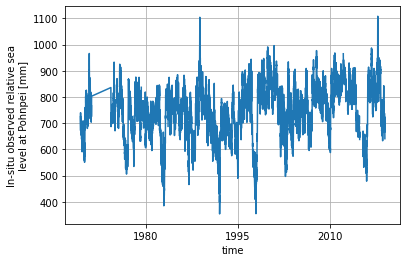

In [38]:
fig, ax = plt.subplots()
sea_level = d['Pohnpei'].sea_level
sea_level.plot(ax=ax)
ax.grid()

d['Pohnpei']

In [40]:
# Save all the timeseries plots
# Runtime ~1.5 mins
for station_name in list(d.keys()):
    fig, ax = plt.subplots(figsize=(8,4))
    sea_level = d[station_name].sea_level
    record_id = d[station_name].record_id
    for i in range(len(np.unique(record_id))):
        record_num = np.unique(record_id)[i]
        sea_level.where(record_id == record_num).plot(
            ax=ax, color='C{}'.format(i), label='ID #{}'.format(record_num)
        )
    ax.legend(bbox_to_anchor=(1,0.5))
    ax.grid()

    ax.set(
        title='In-situ observed relative sea level, {}'.format(station_name),
        ylabel='Sea level [mm]'
    )
    fig.tight_layout()

    save_name = re.sub('[^A-Za-z0-9 ]+', '', station_name).replace(' ', '_').lower()
    path = os.path.join(attrs.VISUALIZATION_PATH, 'tide_gauge_timeseries/')
    fig.savefig(os.path.join(path, save_name))
    plt.close()
    

## Save separate tide gauges as netcdfs 

In case people want to use different packages than xarray for using netcdfs, we save datasets into `data/tide_gauge_timeseries/` as separate netcdfs.

In [28]:
## Runtime ~2min
for station_name, ds in d.items():
    path = os.path.join(attrs.DATA_PATH, 'tide_gauge_timeseries')
    save_name = re.sub('[^A-Za-z0-9 ]+', '', station_name).replace(' ', '_').lower()
    filename = os.path.join(path, save_name)
    ds.to_netcdf(filename + '.nc')

In [ ]:
def expand_time_coord(sea_level):
    """Expands time dimension to range to maximumum timespan"""
    tmax = attrs.tmax
    tmin = attrs.tmin
    full_timespan = xr.DataArray(pd.date_range(start=tmin, end=tmax, freq='D'), dims='time')
    return sea_level.interp(time=full_timespan)